In [1]:
#tensorflow installation 
#https://www.youtube.com/watch?v=usR2LQuxhL4

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
import ops as utils_ops
import label_map_util
import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [4]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "../models/research/object_detection/data/mscoco_label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.

TEST_IMAGE_PATHS = ["../images/testimagesandbot.jpg"]


In [7]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [9]:
detection_model.signatures['serving_default'].output_dtypes

{'num_detections': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32}

In [10]:
detection_model.signatures['serving_default'].output_shapes

{'num_detections': TensorShape([None]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'detection_boxes': TensorShape([None, 100, 4])}

In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [12]:
def compressImageByTwo(image_np, iteration):
    if iteration==0:
        return image_np
    else:
        width=image_np.shape[1]
        height=image_np.shape[0]
        output = np.array(Image.new("RGB", (image_np.shape[1]//2, image_np.shape[0]//2), (255, 255, 255)))
        for i in range(height//2):
            for j in range(width//2):
                output[i][j]=image_np[i*2][j*2]

        print(output.shape)
        return compressImageByTwo(output,iteration-1)
                

def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    img = np.array(Image.new("RGB", (image_np.shape[1], image_np.shape[0]), (255, 255, 255)))
    print(image_np.shape)
    print(img.shape)
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        img,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8,
        skip_scores=True,
        skip_labels=True,)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8,
        skip_scores=True,
        skip_labels=True,)
    
    pil_image=Image.fromarray(img)
    
    pil_image.save(str(image_path)+"_inferenced.jpg")
    pil_imageO=Image.fromarray(image_np)
    
    pil_imageO.save(str(image_path)+"_inferenced_Original.jpg")
    return (np.array(pil_image),np.array(pil_imageO))

(480, 640, 3)
(480, 640, 3)
end of the function
end of the function


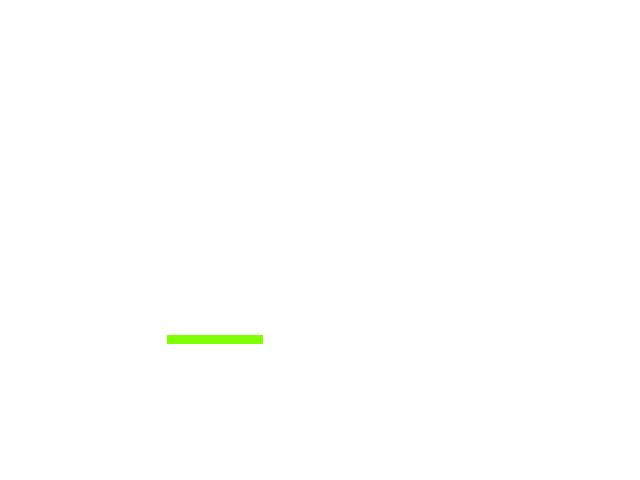

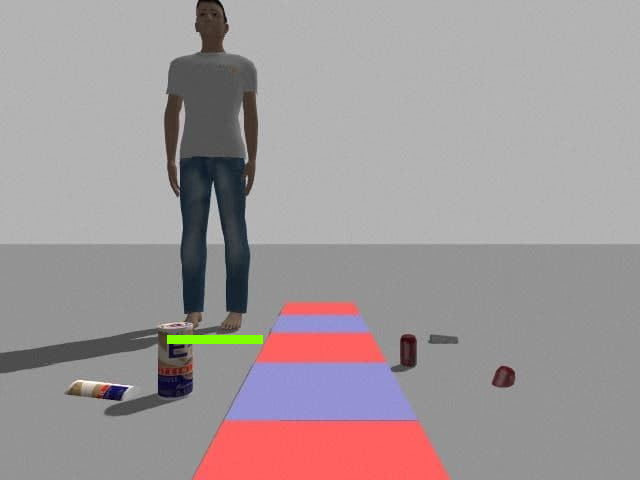

In [13]:
imageList=list()
for i in range(len(TEST_IMAGE_PATHS)):
    imageList.append(show_inference(detection_model, TEST_IMAGE_PATHS[i]))
    display(Image.fromarray(imageList[i][0]))
    display(Image.fromarray(imageList[i][1]))



In [16]:
DEFAULT_DEPTH = 1 #ft

class PathCalculator: 
    #https://www.rapidtables.com/web/tools/pixel-ruler.html
    #https://mycurvefit.com/
    
    def __init__(self, image_np,image_npO):
        self.compressResolution=(50,50)
        self.image_np=np.array(Image.fromarray(image_np.copy())
                               .resize(self.compressResolution,Image.ANTIALIAS))
        self.image_npO=np.array(Image.fromarray(image_npO.copy())
                                .resize(self.compressResolution,Image.ANTIALIAS))
        self.solutionPPath=list()
        self.distancePenalty=1.5
        self.width=self.image_np.shape[1]
        self.height=self.image_np.shape[0]
        self.scalingFactor=(self.width/self.compressResolution[0]*20,self.height/self.compressResolution[1]*2000)
        self.startingPixel=(self.height-2,17)
        #self.startingPixel=(self.height-2,self.width//2)
        self.endingPixel=(1,self.width//2)
        print(self.startingPixel)
        print(self.endingPixel)
        self.isBorder={}
        self.pixelToNode={}
        self.NodeToPixel={}
        count=0
        newImage=self.image_np.copy()
        for i in range(self.height):
            for j in range(self.width):
                self.pixelToNode[(i,j)]=count
                self.NodeToPixel[count]=(i,j)
                pixel=self.image_np[i][j]
                if pixel[0]==255 and pixel[1]==255 and pixel[2]==255:
                    self.isBorder[count]=False
                else:
                    self.isBorder[count]=True
                    newImage[i][j][0]=0
                    newImage[i][j][1]=0
                    newImage[i][j][2]=0
                count+=1
        display(Image.fromarray(self.image_np))
        display(Image.fromarray(newImage))
        #print([str(self.NodeToPixel[key])+":"+str(self.isBorder[key]) for key in self.isBorder.keys() if self.isBorder[key]==True])
        self.startingNode=self.pixelToNode[self.startingPixel]
        self.endingNode=self.pixelToNode[self.endingPixel]
        print(self.startingNode)
        print(self.endingNode)
        self.graph=list()
        for i in range(self.height):
            for j in range(self.width):
                '''
                if i==0 or j==0 or i==self.height-1 or j==self.width-1:
                    adj=[1 for i in range(self.width*self.height)]
                    currentNode=self.pixelToNode[(i,j)]
                    self.graph.append(adj)
                else:
                '''
                adj=[0 for i in range(self.width*self.height)]
                currentNode=self.pixelToNode[(i,j)]
                if i>0:
                    uNode=self.pixelToNode[(i-1,j)]
                    if self.isBorder[uNode]:
                        adj[uNode]=9999
                    else:
                        adj[uNode]=abs(j-self.startingPixel[1])*self.distancePenalty+1

                if j>0:
                    lNode=self.pixelToNode[(i,j-1)]
                    if self.isBorder[lNode]:
                        adj[lNode]=9999
                    else:
                        adj[lNode]=abs(j-1-self.startingPixel[1])*self.distancePenalty+1

                if j<self.width-1:
                    rNode=self.pixelToNode[(i,j+1)]
                    if self.isBorder[rNode]:
                        adj[rNode]=9999
                    else:
                        adj[rNode]=abs(j+1-self.startingPixel[1])*self.distancePenalty+1

                if i<self.height-1:
                    dNode=self.pixelToNode[(i+1,j)]
                    if self.isBorder[dNode]:
                        adj[dNode]=9999
                    else:
                        adj[dNode]=abs(j-self.startingPixel[1])*self.distancePenalty+1
                
                #print(currentNode)
                #print(adj)
                self.graph.append(adj)
    
    def pixelCoveredToDistanceCoveredRL(self,pixelStart, pixelEnd):
        #y = 1234.47 + (0.004702566 - 1234.47)/(1 + (x/8289.626)^3.058906) 
        #pixel away from bottom->distance(ft) covered per pixel left to right
        
        pixelAway=self.height-pixelStart[0]
        pixelCovered=abs(pixelStart[1]-pixelEnd[1])
        
        #return (1234.47 + (0.004702566 - 1234.47)/(1 + (pixelAway/8289.626)**3.058906))*pixelCovered*self.scalingFactor[0]
        #return (6092.447 + (0.005479013 - 6092.447)/(1 + (pixelAway/215.6)**5.382167))*pixelCovered
        return y = -17854660 + (325.4808 - -17854660)/(1 + (x/59954040)^0.7429366)
        
    def pixelCoveredToDistanceCoveredFB(self,pixelStart, pixelEnd):
        #y = 2192701 + (1.927978 - 2192701)/(1 + (x/9308.816)^3.33469)
        #pixel away from bottom->total distance(ft) covered front to back
        
        pixelAwayStart=self.height-pixelStart[0]
        pixelAwayEnd=self.height-pixelEnd[0]
        
        d1=2192701 + (1.927978 - 2192701)/(1 + (pixelAwayStart/9308.816)**3.33469)*self.scalingFactor[1]
        d2=2192701 + (1.927978 - 2192701)/(1 + (pixelAwayEnd/9308.816)**3.33469)*self.scalingFactor[1]
        #d1=2651658 + (2.27663 - 2651658)/(1 + (pixelAwayStart/139.5231)**6.530391)
        #d2=2651658 + (2.27663 - 2651658)/(1 + (pixelAwayEnd/139.5231)**6.530391)
        return (d2-d1)
    
    def minDistance(self,dist,queue): 
        # Initialize min value and min_index as -1 
        minimum = float("Inf") 
        min_index = -1
          
        for i in range(len(dist)): 
            if dist[i] < minimum and i in queue: 
                minimum = dist[i] 
                min_index = i 
        return min_index 
  
    def getPath(self, parent, j): 
        output=list()
        #Base Case : If j is source 
        if parent[j] == -1 :  
            #print(j),
            output.append(j)
            return output
        output=self.getPath(parent , parent[j]) 
        #print(j), 
        output.append(j)
        return output
          
    def getSolution(self, dist, parent): 
        src = self.startingNode
        #print("Vertex \t\tDistance from Source\tPath") 
        solutions=list()
        for i in range(1, len(dist)): 
            #print("\n%d --> %d \t\t%d \t\t\t\t\t" % (src, i, dist[i])), 
            solutions.append(self.getPath(parent,i))
        return solutions
    
    '''Function that implements Dijkstra's single source shortest path 
    algorithm for a graph represented using adjacency matrix 
    representation'''
    def dijkstra(self): 
  
        row = len(self.graph) 
        col = len(self.graph[0]) 
  
        # Initialize all distances as INFINITE  
        dist = [float("Inf")] * row 
  
        parent = [-1] * row 
  
        dist[self.startingNode] = 0

        queue = [] 
        for i in range(row): 
            queue.append(i) 
              
        #Find shortest path for all vertices 
        while queue: 
  
            u = self.minDistance(dist,queue)
            queue.remove(u) 
            
            for i in range(col): 
                '''Update dist[i] only if it is in queue, there is 
                an edge from u to i, and total weight of path from 
                src to i through u is smaller than current value of 
                dist[i]'''
                if self.graph[u][i] and i in queue: 
                    if dist[u] + self.graph[u][i] < dist[i]: 
                        dist[i] = dist[u] + self.graph[u][i] 
                        parent[i] = u 
        self.solutionPPath=[self.NodeToPixel[n] for n in self.getSolution(dist,parent)[self.endingNode-1]]
        print(self.solutionPPath)
        return self.solutionPPath
    
    def addPathToImage(self):
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) in self.solutionPPath:
                    self.image_np[i][j][0]=255
                    self.image_np[i][j][1]=0
                    self.image_np[i][j][2]=0
                    self.image_npO[i][j][0]=255
                    self.image_npO[i][j][1]=0
                    self.image_npO[i][j][2]=0
    
    def pixelInstructions(self):
        if len(self.solutionPPath)==0:
            print("call dijkstra first to calculate path")
            return;
        self.addPathToImage()
        display(Image.fromarray(self.image_np).resize((300,300),Image.ANTIALIAS))
        display(Image.fromarray(self.image_npO).resize((300,300),Image.ANTIALIAS))
        
        directionP=list()
        instructionP=list()
        
        currentP=self.solutionPPath[0]
        for p in self.solutionPPath[1:len(self.solutionPPath)]:
            directionP.append(self.getDirection(currentP,p))
            currentP=p
        
        currentDirection=directionP[0]
        count=1
        for i in range(1,len(directionP)):
            if (not directionP[i]==currentDirection) or i==len(directionP)-1:
                instructionP.append((currentDirection,count))
                currentDirection=directionP[i]
                count=1
            else:
                count+=1
        
        print(directionP)
        print(instructionP)
        return instructionP
    
    #distance is in feet
    def getDistanceInstruction(self):
        pI=self.pixelInstructions()
        distanceI=list()
        pixelCount=0
        for I in pI:
            if I[0]=="forward":
                startPixel=self.solutionPPath[pixelCount]
                pixelCount+=I[1]
                endPixel=self.solutionPPath[pixelCount]
                distanceI.append(("forward",self.pixelCoveredToDistanceCoveredFB(startPixel,endPixel)))
                
            elif I[0]=="backward":
                startPixel=self.solutionPPath[pixelCount]
                pixelCount+=I[1]
                endPixel=self.solutionPPath[pixelCount]
                distanceI.append(("backward",self.pixelCoveredToDistanceCoveredFB(startPixel,endPixel)))
                
            elif I[0]=="left":
                startPixel=self.solutionPPath[pixelCount]
                pixelCount+=I[1]
                endPixel=self.solutionPPath[pixelCount]
                distanceI.append(("left",self.pixelCoveredToDistanceCoveredRL(startPixel,endPixel)))
                
            elif I[0]=="right":
                startPixel=self.solutionPPath[pixelCount]
                pixelCount+=I[1]
                endPixel=self.solutionPPath[pixelCount]
                distanceI.append(("right",self.pixelCoveredToDistanceCoveredRL(startPixel,endPixel)))
                
            else:
                print("error something gone wrong in distance isntruction")
        
        print(distanceI)
        return distanceI
            
    #p1 is current pixel, p2 is the next pixel
    def getDirection(self,p1,p2):
        if p2[0]<p1[0]:
            direction="forward"
        elif p2[0]>p1[0]:
            direction="backward"
        elif p2[1]<p1[1]:
            direction="left"
        elif p2[1]>p1[1]:
            direction="right"
        else:
            direction="error"
        return direction


(48, 25)
(1, 25)


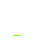

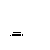

2425
75
[(48, 25), (47, 25), (46, 25), (45, 25), (44, 25), (43, 25), (42, 25), (41, 25), (40, 25), (39, 25), (38, 25), (37, 25), (36, 25), (35, 25), (34, 25), (33, 25), (32, 25), (31, 25), (30, 25), (29, 25), (28, 25), (27, 25), (26, 25), (25, 25), (24, 25), (23, 25), (22, 25), (21, 25), (20, 25), (19, 25), (18, 25), (17, 25), (16, 25), (15, 25), (14, 25), (13, 25), (12, 25), (11, 25), (10, 25), (9, 25), (8, 25), (7, 25), (6, 25), (5, 25), (4, 25), (3, 25), (2, 25), (1, 25)]


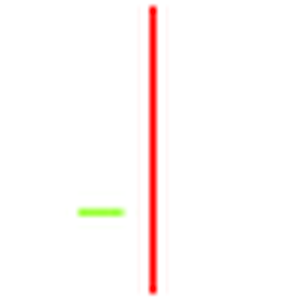

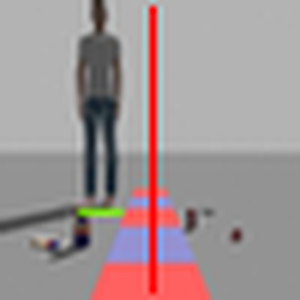

['forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward']
[('forward', 46)]
[('forward', 103.12973308563232)]


[('forward', 103.12973308563232)]

In [17]:
testl=[]
g=PathCalculator(imageList[0][0],imageList[0][1])
g.dijkstra()
g.getDistanceInstruction()